In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qulacs import Observable, QuantumState, QuantumCircuit, ParametricQuantumCircuit, DensityMatrix
from qulacs.gate import  X, H, Z, DepolarizingNoise, DephasingNoise, AmplitudeDampingNoise, TwoQubitDepolarizingNoise, CNOT, merge, RY, RZ, DenseMatrix

from enum import Enum
from qulacsvis import circuit_drawer
from scipy.optimize import minimize


In [2]:
#１次元横磁場イジング模型のハミルトニアンを定義
n_qubits = 7
depth = 12
transverse_Ising_hamiltonian = Observable(n_qubits)
J = -1.0
h = -1.0
for i in range(n_qubits):
    transverse_Ising_hamiltonian.add_operator(J, f"Z {i} Z {(i+1)%n_qubits}")
    transverse_Ising_hamiltonian.add_operator(h, f"X {i}")

In [3]:
class PauliGate(Enum):
    I_gate = [[1, 0], [0, 1]]
    X_gate = [[0, 1], [1, 0]]
    Y_gate = [[0, 0 - 1j], [0 + 1j, 0]]
    Z_gate = [[1, 0], [0, -1]]


def create_hamiltonian(n_qubits, cn, bn, gamma):
        XX = np.array(np.zeros(2**n_qubits))
        YY = np.array(np.zeros(2**n_qubits))
        Zn = np.array(np.zeros(2**n_qubits))
        for k in range(n_qubits - 1):
            for l in range(n_qubits):
                if k == l:
                    if l == 0:
                        hamiX = PauliGate.X_gate.value
                        hamiY = PauliGate.Y_gate.value
                    else:
                        hamiX = np.kron(hamiX, PauliGate.X_gate.value)
                        hamiY = np.kron(hamiY, PauliGate.Y_gate.value)

                elif k + 1 == l:
                    hamiX = np.kron(hamiX, PauliGate.X_gate.value)
                    hamiY = np.kron(hamiY, PauliGate.Y_gate.value)
                else:
                    if l == 0:
                        hamiX = PauliGate.I_gate.value
                        hamiY = PauliGate.I_gate.value
                    else:
                        hamiX = np.kron(hamiX, PauliGate.I_gate.value)
                        hamiY = np.kron(hamiY, PauliGate.I_gate.value)
            XX = XX + 0.5 * cn[k] * (1 + gamma) * hamiX
            YY = YY + 0.5 * cn[k] * (1 - gamma) * hamiY

        for m in range(n_qubits):
            for n in range(n_qubits):
                if m == n:
                    if n == 0:
                        hamiZ = PauliGate.Z_gate.value
                    else:
                        hamiZ = np.kron(hamiZ, PauliGate.Z_gate.value)

                else:
                    if n == 0:
                        hamiZ = PauliGate.I_gate.value
                    else:
                        hamiZ = np.kron(hamiZ, PauliGate.I_gate.value)

            Zn = Zn + bn[m] * hamiZ

        hamiltonian = XX + YY + Zn
        return np.linalg.eigh(hamiltonian)

In [4]:
cn = [1] * n_qubits
bn = [0] * n_qubits
gamma = 0

diag, eigen_vecs = create_hamiltonian(n_qubits, cn, bn, gamma)

def create_hamiltonian_gate(n_qubits, t):
        time_evol_op = np.dot(
            np.dot(eigen_vecs, np.diag(np.exp(-1j * t * diag))), eigen_vecs.T.conj(),
        )
        return DenseMatrix([i for i in range(n_qubits)], time_evol_op)

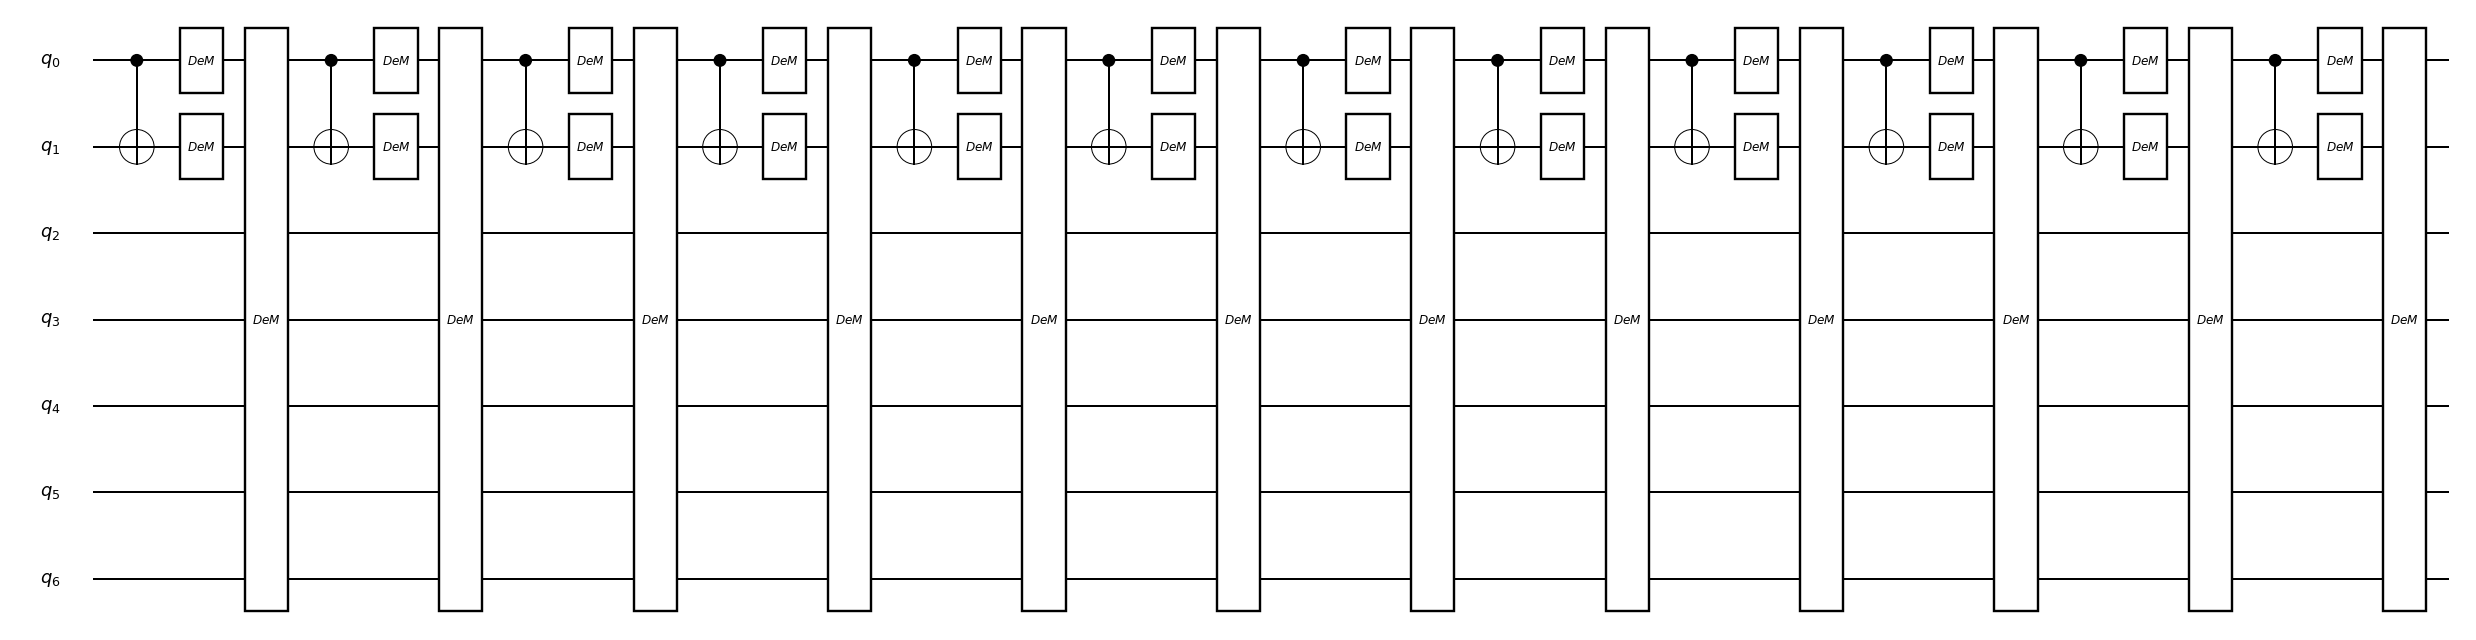

In [5]:
def Circuit(n_qubits, depth, params):
        circuit = ParametricQuantumCircuit(n_qubits)
        for d in range(depth):
                circuit.add_gate(CNOT(0, 1))
                circuit.add_gate(merge(RY(0, params[depth + (4 * d) + 0]), RZ(0, params[depth + (4 * d) + 1])))
                circuit.add_gate(merge(RY(1, params[depth + (4 * d) + 2]), RZ(1, params[depth + (4 * d) + 3])))
                circuit.add_gate(create_hamiltonian_gate(n_qubits, params[d]))

        return circuit


# 1 * n_qubits time params / 4 theta params for each depth
params_initial = np.random.uniform(-1.0, 1.0, depth + (4 * depth))
# params_initial = np.zeros(depth + (4 * depth))
circuit = Circuit(n_qubits, depth, params_initial)

#ansatz回路を表示
circuit_drawer(circuit, "mpl")

In [6]:
#コスト関数を定義。ここではエネルギー期待値がコスト関数。
def get_cost(params):
        state = QuantumState(n_qubits)
        circuit = Circuit(n_qubits, depth, params)
        circuit.update_quantum_state(state)
        return transverse_Ising_hamiltonian.get_expectation_value(state)

In [7]:
#上で定義したansatz回路のもとで、コスト関数を最小化する。
minimized_costfunction = minimize(get_cost, params_initial, method='BFGS')

#コスト関数の最小値を表示
print(minimized_costfunction.fun)

-8.815193711763012


In [8]:
params_true = []
for i, p in enumerate(minimized_costfunction.x):
    params_true.append(p)

In [9]:
def NoisyCircuit(n_qubits, depth, params, error_rate):
        circuit = ParametricQuantumCircuit(n_qubits)
        for d in range(depth):
                circuit.add_gate(CNOT(0, 1))
                circuit.add_gate(DepolarizingNoise(0, error_rate))
                circuit.add_gate(DepolarizingNoise(1, error_rate))
                circuit.add_gate(merge(RY(0, params[depth + (4 * d) + 0]), RZ(0, params[depth + (4 * d) + 1])))
                circuit.add_gate(DepolarizingNoise(0, error_rate))
                circuit.add_gate(DepolarizingNoise(1, error_rate))
                circuit.add_gate(merge(RY(1, params[depth + (4 * d) + 2]), RZ(1, params[depth + (4 * d) + 3])))
                circuit.add_gate(DepolarizingNoise(0, error_rate))
                circuit.add_gate(DepolarizingNoise(1, error_rate))
                circuit.add_gate(create_hamiltonian_gate(n_qubits, params[d]))

        return circuit


def get_noisy_cost(params, error_rate):
        state = QuantumState(n_qubits)
        circuit = NoisyCircuit(n_qubits, depth, params_true, error_rate)
        circuit.update_quantum_state(state)
        return transverse_Ising_hamiltonian.get_expectation_value(state)

print(get_noisy_cost(params_true, 0.01))


-4.550064077480691
